In [0]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.45)


In [3]:
target_stock_name='AAPL'
target_stock_start='2017-01-01'

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo( target_stock_name, start=target_stock_start).reset_index()
df_full.to_csv(f'{target_stock_name}.csv',index=False)


# set Date as index
df = pd.read_csv(f'{target_stock_name}.csv')
df.set_index('Date', inplace=True)
df.head()


[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,115.800003,116.330002,114.760002,116.150002,111.286987,28781900
2017-01-04,115.849998,116.510002,115.750000,116.019997,111.162437,21118100
2017-01-05,115.919998,116.860001,115.809998,116.610001,111.727715,22193600
2017-01-06,116.779999,118.160004,116.470001,117.910004,112.973305,31751900
2017-01-09,117.949997,119.430000,117.940002,118.989998,114.008080,33561900


In [4]:
!wget -O tesla.csv https://www.dropbox.com/s/na2vurooejpew59/TSLA.csv?dl=1

--2019-09-05 16:05:29--  https://www.dropbox.com/s/na2vurooejpew59/TSLA.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/na2vurooejpew59/TSLA.csv [following]
--2019-09-05 16:05:29--  https://www.dropbox.com/s/dl/na2vurooejpew59/TSLA.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb3d8880b267cdd43d75a9b775f.dl.dropboxusercontent.com/cd/0/get/An8JPZ9J3WgtMdW454GYrvYeuV85Wr4-UF6qwtcHmJY5SHY5W8Mr8wughp1b9eoTy2A6xT19M-IDreZcL7jbLUu5hkO0g5FkOWuYYqEhRXUE69I4WNikdQtNtYcCchPuD4o/file?dl=1# [following]
--2019-09-05 16:05:30--  https://ucb3d8880b267cdd43d75a9b775f.dl.dropboxusercontent.com/cd/0/get/An8JPZ9J3WgtMdW454GYrvYeuV85Wr4-UF6qwtcHmJY5SHY5W8Mr8wughp1b9eoTy2A6xT19M-IDreZcL7jbLUu5hkO0g5FkOWuYYqEhRXUE69I4WNikdQtNtYcC

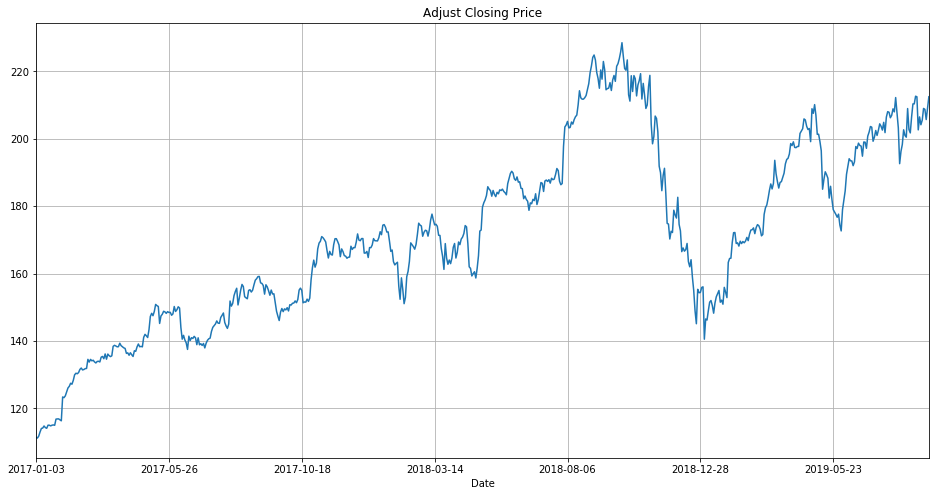

In [5]:
df['Adj Close'].plot(label = 'TESLA', figsize = (16, 8), title = 'Adjust Closing Price', grid=True)

<p>None = np.newaxis</p>
to expand to higher dimension!
<p></p>


In [0]:
# use the past 32 days prices as traing data to predict the 33rd price
window_size = 32

# numbers of total training sets
num_samples = len(df) - window_size

# creat int index for each data in each training set
indices = np.arange(num_samples).astype(np.int)[:, None] + np.arange(window_size+1).astype(np.int) #add vector to each rows of matrix

# creat 2D matrix of training sets via indicis
data = df['Adj Close'].values[indices]

In [0]:
# split input(past 32 days) and outcome(33rd day)
input_x = data[:,:-1]
output_y = data[:, -1]

In [0]:
# split training set and data set: to see the performance of our prediction in last 20% data
split_fraction = 0.8

# get the break point
index_split = int(split_fraction * num_samples)

# split data
input_train = input_x[:index_split]
output_train = output_y[:index_split]
input_test = input_x[index_split:]
output_test = output_y[index_split:]

# Method I ---- ridge regression

add a penalty to loss function<br>
-> avoid overfitting<br>
-> make prediction less sensitive to training data<br>
###formula:
minimize Σ(residual^2) + ƛ * Σ(coefficient^2)

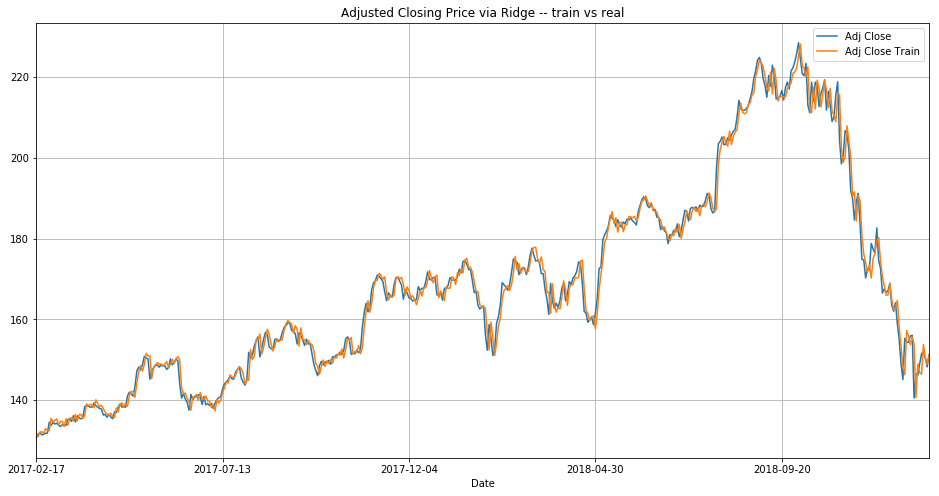

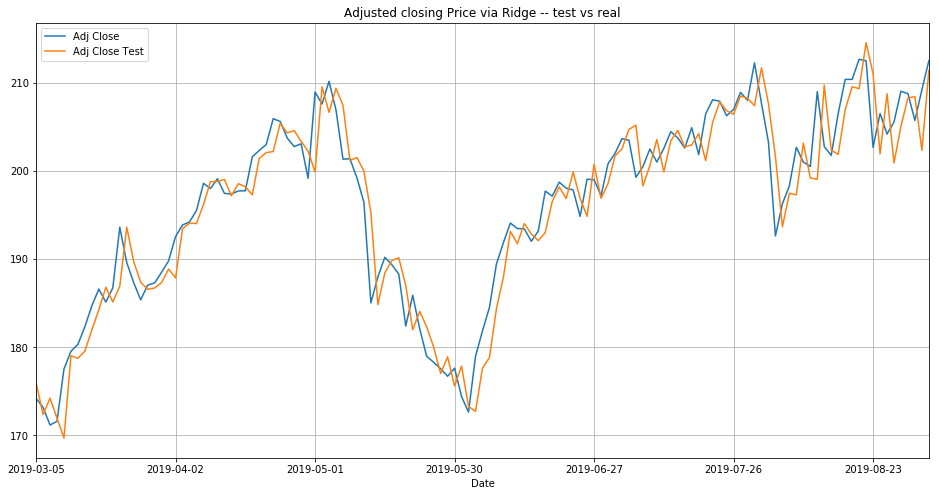

In [9]:
from sklearn.linear_model import Ridge


# open model and train
ridge_model = Ridge()
ridge_model.fit(input_train, output_train)


# inference
infer_train_ridge = ridge_model.predict(input_train)
infer_test_ridge = ridge_model.predict(input_test)


# plot pred training data vs real-world data 
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace = True) # drop irrelevant columns
df_ridge = df_ridge.iloc[window_size:index_split] # we don't infer the vary past 32 days -> start from 33rd dat to breakpoint
df_ridge['Adj Close Train'] = infer_train_ridge[:-window_size]
df_ridge.plot(label='TESLA train vs real', figsize=(16,8), title='Adjusted Closing Price via Ridge -- train vs real', grid=True)

# plot inference vs real-world data
df_ridge_infer = df.copy()
df_ridge_infer.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge_infer = df_ridge_infer.iloc[window_size+index_split:] # start from the 33rd day after breakpoint
df_ridge_infer['Adj Close Test'] = infer_test_ridge
df_ridge_infer.plot(label='TESLA test vs real', figsize=(16, 8), title = 'Adjusted closing Price via Ridge -- test vs real', grid=True)
# df_ridge_infer.head()


#Method II ---- Gradient Boosting Trees

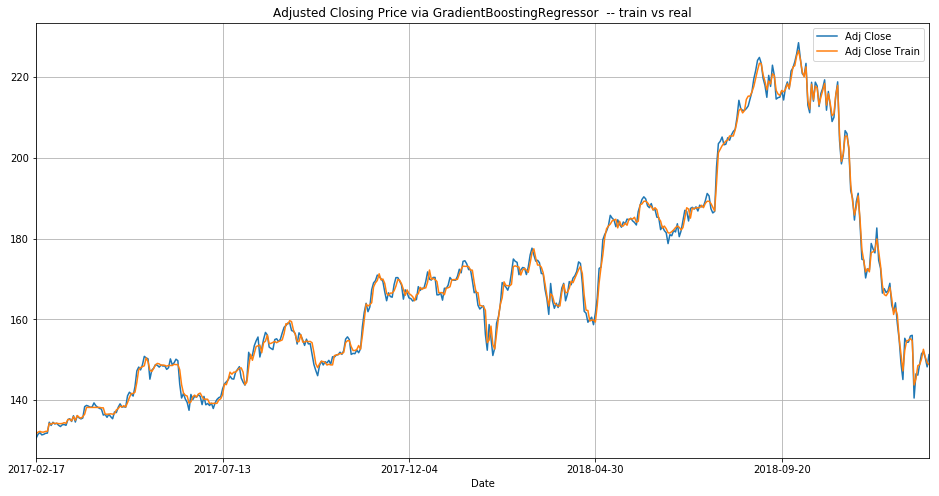

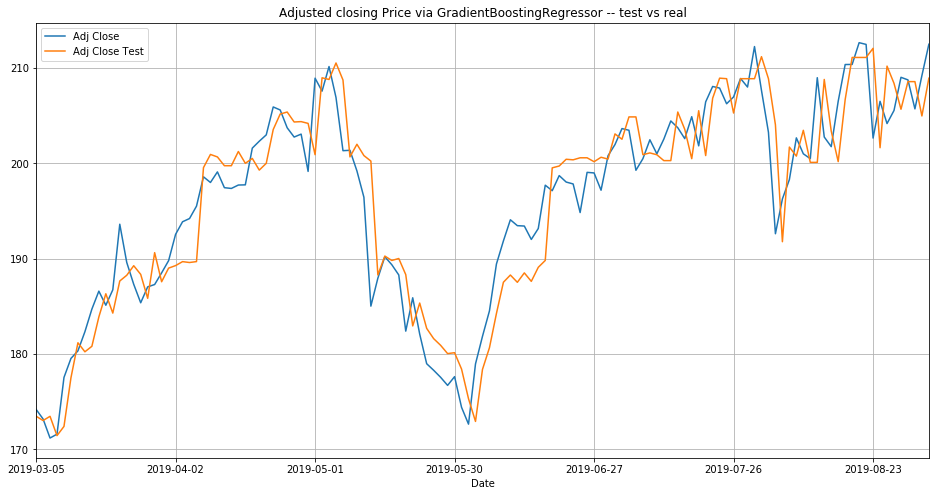

In [10]:
from sklearn.ensemble import GradientBoostingRegressor


# open model and train
gb_model = GradientBoostingRegressor()
gb_model.fit(input_train, output_train)

# Infer
infer_train_gb = gb_model.predict(input_train)
infer_test_gb = gb_model.predict(input_test)
# print(len(infer_test_gb))

# plot pred training data vs real-world data 
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace = True) # drop irrelevant columns
df_gb = df_gb.iloc[window_size:index_split] # we don't infer the vary past 32 days -> start from 33rd dat to breakpoint
df_gb['Adj Close Train'] = infer_train_gb[:-window_size]
df_gb.plot(label='TESLA train vs real', figsize=(16,8), title='Adjusted Closing Price via GradientBoostingRegressor  -- train vs real', grid=True)

# plot inference vs real-world data
df_gb_infer = df.copy()
df_gb_infer.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb_infer = df_gb_infer.iloc[window_size+index_split:] # start from the 33rd day after breakpoint
df_gb_infer['Adj Close Test'] = infer_test_gb
df_gb_infer.plot(label='TESLA test vs real', figsize=(16, 8), title = 'Adjusted closing Price via GradientBoostingRegressor -- test vs real', grid=True)


# Method III ---- Lasso

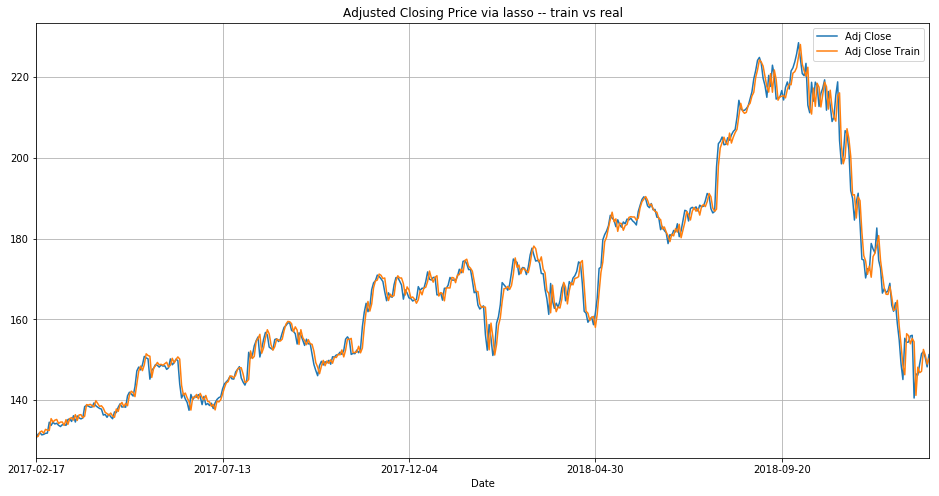

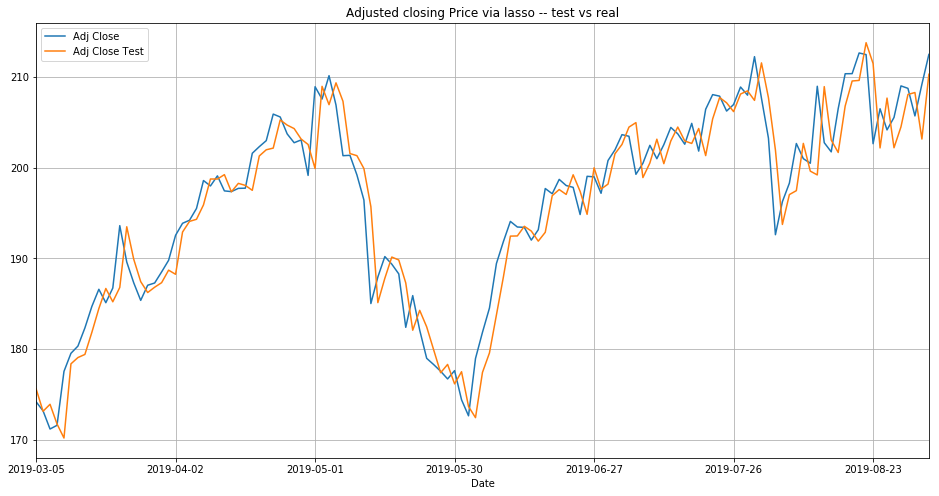

In [11]:
from sklearn.linear_model import Lasso


# open model and train
lasso_model = Lasso(alpha = 0.1)
lasso_model.fit(input_train, output_train)


# inference
infer_train_lasso = lasso_model.predict(input_train)
infer_test_lasso = lasso_model.predict(input_test)


# plot pred training data vs real-world data 
df_lasso = df.copy()
df_lasso.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace = True) # drop irrelevant columns
df_lasso = df_lasso.iloc[window_size:index_split] # we don't infer the vary past 32 days -> start from 33rd dat to breakpoint
df_lasso['Adj Close Train'] = infer_train_lasso[:-window_size]
df_lasso.plot(label='TESLA train vs real', figsize=(16,8), title='Adjusted Closing Price via lasso -- train vs real', grid=True)

# plot inference vs real-world data
df_lasso_infer = df.copy()
df_lasso_infer.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_lasso_infer = df_lasso_infer.iloc[window_size+index_split:] # start from the 33rd day after breakpoint
df_lasso_infer['Adj Close Test'] = infer_test_lasso
df_lasso_infer.plot(label='TESLA test vs real', figsize=(16, 8), title = 'Adjusted closing Price via lasso -- test vs real', grid=True)


# predict future n days stock price


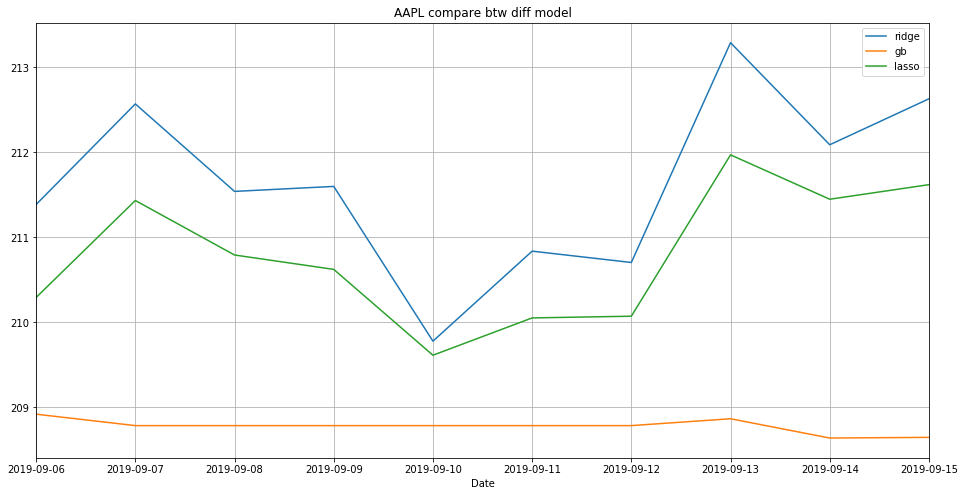

In [18]:
future_window = 10


from datetime import datetime, timedelta


def pred_future_stock( model, past_stock, future_window):
  plot_df = df.copy()
  plot_df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
  
  
  #predict the future n days stock price
  for _ in range(future_window):  
    
    # access next date
    next_date = datetime.strptime(plot_df.index[-1], '%Y-%m-%d') + timedelta(days=1)
    
    # predict next stock
    next_stock = model.predict(past_stock.reshape(1, -1))
    
    # add outcome to past_stock and update the past 32 days stock price    
    tmp = past_stock.tolist()[-window_size+1:] 
    tmp.append(*next_stock)
    past_stock = np.array(tmp)
    
    # add to dataframe
    dic = { 'Adj Close':next_stock[0] }
    plot_df.loc[ next_date.strftime("%Y-%m-%d") ] = dic

  # return prediction
  return plot_df[-future_window:]

  
    

pred_df = []
pred_df.append( pred_future_stock(ridge_model, input_test[-1], future_window) )
pred_df.append( pred_future_stock(gb_model, input_test[-1], future_window) ) 
pred_df.append( pred_future_stock(lasso_model, input_test[-1], future_window) )
name = ['ridge', 'gb', 'lasso']


final_df = pd.concat( [ *pred_df ] , axis=1, join_axes=[pred_df[0].index])
final_df.columns = name
final_df.plot(figsize=(16, 8), title=f'{target_stock_name} compare btw diff model', grid = True)



